In [378]:
# Filter trajectories to maximum length to not overrepresent long trajectories that are often artifactual
# Very low fraction of trajectories are longer than 10 frames

# Only for robustness analysis

import pandas as pd
import numpy as np

max_length = np.inf
min_length = 3

paths = pd.read_csv('../data/single-molecule-tracking/experiment_conditions.csv')

for i in range(len(paths)):
    print(i+1,'of',len(paths))
    df = pd.read_csv(paths.iloc[i].filepath)
    
    n_frames = np.zeros(int(df.trajectory.max()))
    for t in df.trajectory.to_numpy(dtype=np.integer):
        n_frames[t-1] += 1

    # filtered_trajectories = list(np.nonzero(n_frames<=max_length)[0])
    filtered_trajectories = list(np.nonzero(n_frames>=min_length)[0])

    df.query('trajectory==@filtered_trajectories').to_csv(paths.iloc[i].filepath[:-4] + '.filtered' + '.csv')

1 of 19
2 of 19
3 of 19
4 of 19
5 of 19
6 of 19
7 of 19
8 of 19
9 of 19
10 of 19
11 of 19
12 of 19
13 of 19
14 of 19
15 of 19
16 of 19
17 of 19
18 of 19
19 of 19


In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, pickle
from saspt import RBME, GAMMA, StateArrayDataset

# parameters
paths = pd.read_csv('../data/single-molecule-tracking/experiment_conditions.csv')

file_name = "../data/single-molecule-tracking/2024_03_06_200_unfiltered_all_occupancy.pkl" # primary analysis with params above

# Secondary analyses to see if increased iterations reveals anything significant; narrowed distributions but nothing novel emerging
# file_name = "../data/single-molecule-tracking/2024_03_06_1000_unfiltered_all_occupancy.pkl" # secondary analysis with 1000 iterations

# Secondary analyses filtering out rare, long trajectories that can be immobile spots (limit to <=10 frames total length)
# file_name = "../data/single-molecule-tracking/2024_03_05_200_filtered_long_all_occupancy.pkl"

# Secondary analyses filtering out short trajectories that can be mistaken assignment (limit to >=3 frames total length)
# file_name = "../data/single-molecule-tracking/2024_03_06_200_filtered_short_all_occupancy.pkl"

# Secondary analysis with localization error fixed at 25 nm
# file_name = "../data/single-molecule-tracking/2024_03_06_200_gamma_all_occupancy.pkl"

figure_prefix = '../figures/figure-4/smt-outputs/'
load_file = True
use_filtered_trajectories = False

if load_file:
    with open(file_name, "rb") as file:
        SAD,marginal_naive_occs,marginal_posterior_occs,posterior_occs,posterior_names = pickle.load(file)
else:
    settings = dict(
        likelihood_type = RBME, # primary analysis
        # likelihood_type = GAMMA, # test robustness w/ gamma
        # loc_error = 0.025, # fix localization error with gamma
        pixel_size_um = 0.1,
        frame_interval = 0.033,
        focal_depth = 0.5, # based on empirical observation of track localizations relative to cell width
        path_col = 'filepath',
        condition_col = 'condition',
        progress_bar = True,
        max_iter = 200, # default 200
        sample_size = 1e9, # no max
        splitsize = 10, # default 10
        diff_coefs=np.logspace(-2.0, 1.0, 100)  # 100 diff coefs from 0.01 to 10.0
    )

    if use_filtered_trajectories:
        for i in range(len(paths)):
            paths.loc[i,'filepath'] = paths.iloc[i].filepath[:-4] + '.filtered' + '.csv'

    SAD = StateArrayDataset.from_kwargs(paths, **settings)

print(SAD.raw_track_statistics)
print(SAD.params)

    n_tracks  n_jumps  n_detections  mean_track_length  max_track_length  \
0      24817    68244         93061           3.749889                37   
1      16573    42443         59016           3.560973                82   
2      14926    37966         52892           3.543615                42   
3      13961    35735         49696           3.559630                54   
4      10037    25861         35898           3.576567               123   
5      10195    26609         36804           3.610005               236   
6      13041    36036         49077           3.763285                60   
7      12182    30629         42811           3.514283               200   
8      12300    31110         43410           3.529268               104   
9      13820    34776         48596           3.516353                42   
10     10499    26786         37285           3.551291                44   
11     15405    41192         56597           3.673937                83   
12      7726

In [381]:
# do not run for previous analysis

marginal_naive_occs = SAD.marginal_naive_occs
marginal_posterior_occs = SAD.marginal_posterior_occs

# Optional outputs to see inferred distributions
# SAD.posterior_heat_map(figure_prefix + 'posterior_heat_map.png')
# SAD.posterior_line_plot(figure_prefix + 'posterior_line_plot.png')
# SAD.naive_heat_map(figure_prefix + 'naive_heat_map.png')
# SAD.naive_line_plot(figure_prefix + 'naive_line_plot.png')

# Infer posterior occupancies aggregating conditions
posterior_occs, posterior_names = SAD.infer_posterior_by_condition('condition')

# Save all occupancy estimates
import pickle
file_name = "SAVEPATH.pkl"
    
with open(file_name, "wb") as file:
    pickle.dump([SAD,
                 marginal_naive_occs,
                 marginal_posterior_occs,
                 posterior_occs,
                 posterior_names], file)

[########################################] | 100% Completed | 28.55 s
[########################################] | 100% Completed | 303.55 s


PerMn1 FtsBΔLQ mEos3.2	0.23101297000831603	0.16639276359310753
PerMn1 FtsBΔLQ mEos3.2	0.1873817422860384	0.1559600086504222
PerMn1 FtsBΔLQ mEos3.2	0.14174741629268056	0.1609301067653218
PerMn1 FtsBΔLQ mEos3.2 0.1611 0.0043
PerMn1 FtsBΔLQΔH mEos3.2	0.26560877829466867	0.21091482574482381
PerMn1 FtsBΔLQΔH mEos3.2	0.24770763559917114	0.20289499296541405
PerMn1 FtsBΔLQΔH mEos3.2	0.24770763559917114	0.19620173029791893
PerMn1 FtsBΔLQΔH mEos3.2 0.2033 0.0060


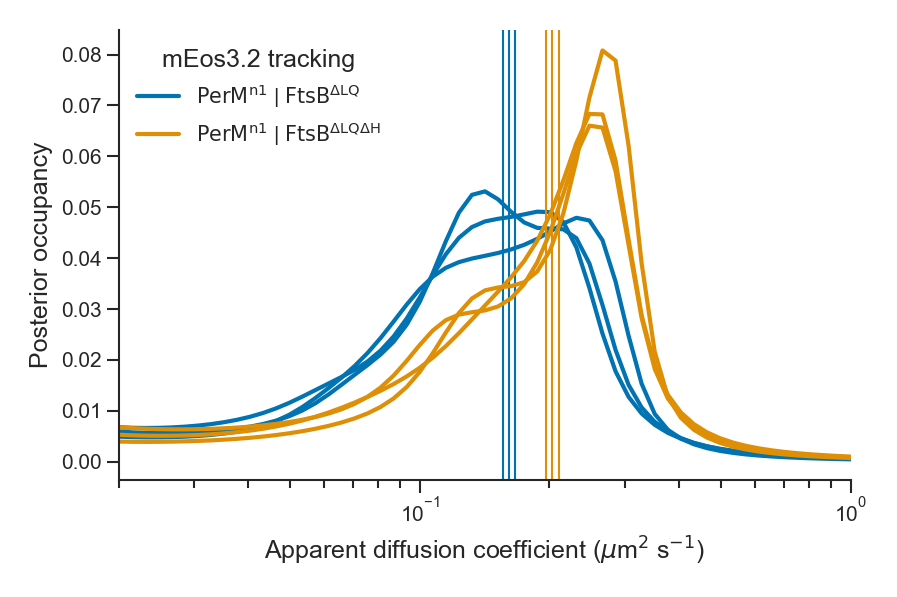

In [111]:
# Figure 4b

import seaborn as sns

sns.set_theme(style='ticks',
              palette=sns.color_palette('colorblind'),
              font='Arial',
              rc={'figure.dpi': 300,
                  'figure.figsize':(7.2,4), # 7.2 inch is full page width
                  'axes.spines.right':False,
                  'axes.spines.top':False,
                  'axes.linewidth':0.5,
                  'font.size':7,
                  'xtick.labelsize':5,
                  'ytick.labelsize':5,
                  'xtick.major.pad':1,
                  'ytick.major.pad':1,
                  'xtick.major.size':3,
                  'ytick.major.size':3,
                  'xtick.minor.size':2,
                  'ytick.minor.size':2,
                  'xtick.major.width':0.5,
                  'ytick.major.width':0.5,
                  'xtick.minor.width':0.5,
                  'ytick.minor.width':0.5,
                  'axes.titlesize':6,
                  'axes.labelsize':6,
                  'legend.fontsize':5,
                  'legend.title_fontsize':6,
                  'axes.labelpad':2})

xlim = [0.02, 1.0]
plot_cumsum = False
use_n = [0,1]

sep = ' | '
pretty_labels = {'PerMn1 FtsBΔLQ':r'$\text{PerM}^\text{n1}$' + sep + r'$\text{FtsB}^\text{ΔLQ}$',
                'PerMn1 FtsBΔLQΔH':r'$\text{PerM}^\text{n1}$' + sep + r'$\text{FtsB}^\text{ΔLQΔH}$',
                'PerMn1 uninduced FtsBΔLQ':r'$\mathbf{↓}\text{PerM}^\text{n1}$' + sep +  r'$\text{FtsB}^\text{ΔLQ}$',
                'Pf3 FtsBΔLQ':r'$\text{Pf3}$' + sep +  r'$\text{FtsB}^\text{ΔLQ}$',
                'Pf3 FtsBΔLQΔH':r'$\text{Pf3}$' + sep +  r'$\text{FtsB}^\text{ΔLQΔH}$'}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
label_values = list(pretty_labels.values())
color_dict = {}
for i in range(len(label_values)):
    color_dict[label_values[i]] = colors[i]

dists = {c: normalize_2d(SAD.marginal_posterior_occs[df.index,:].copy()[:,use_coefs],axis=1) \
                for c, df in SAD.paths.groupby(SAD.condition_col)}

diff_coefs=SAD.likelihood.diff_coefs
use_coefs = (xlim[0]<=diff_coefs)&(diff_coefs<=xlim[1])
plot_diff_coefs = diff_coefs[use_coefs]
condition_names = SAD.conditions

fig = plt.figure(figsize=(3,2))

mean_coeffs = []

for n in use_n:

    mean_coeffs.append([])

    for i in range(len(dists[condition_names[n]])):

        sample_data = dists[condition_names[n]][i,:]

        label = pretty_labels[' '.join(condition_names[n].split(' ')[:-1])]
        c=color_dict[label]
        if i:
            label = None

        if plot_cumsum:
            plt.plot(plt_coefs,sample_data.cumsum(),c=c,label=label,linewidth=1)
        else:
            plt.plot(plt_coefs,sample_data,c=c,label=label,linewidth=1)

        plt.axvline(np.sum(plt_coefs*sample_data),color=c,linestyle='-',linewidth=0.5)
        plt.legend(frameon=False,title='mEos3.2 tracking')
                
        print(condition_names[n],plot_diff_coefs[sample_data.argmax()], np.sum(plot_diff_coefs*sample_data),sep='\t')
        mean_coeffs[-1].append(np.sum(plot_diff_coefs*sample_data))

    print(condition_names[n],f'%0.4f'%np.mean(mean_coeffs[-1]),f'%0.4f'%np.std(mean_coeffs[-1]))
    
plt.xscale('log')   
plt.xlabel(r'Apparent diffusion coefficient ($\mu$m$^{2}$ s$^{-1}$)')
plt.ylabel('Posterior occupancy')
plt.xlim(xlim)
plt.tight_layout()
plt.savefig(figure_prefix + 'replicates_helix_effect.png',dpi=300)
plt.savefig(figure_prefix + 'replicates_helix_effect.svg',dpi=300)

PerMn1 FtsBΔLQΔH mEos3.2 0.2033 0.0060

	P_slow: 0.66
	Mean:   0.185
	s:      0.559

	P_slow: 0.817
	Mean:   0.186
	s:      0.529

	P_slow: 0.729
	Mean:   0.178
	s:      0.468
PerMn1 FtsBΔLQ mEos3.2 0.1611 0.0043


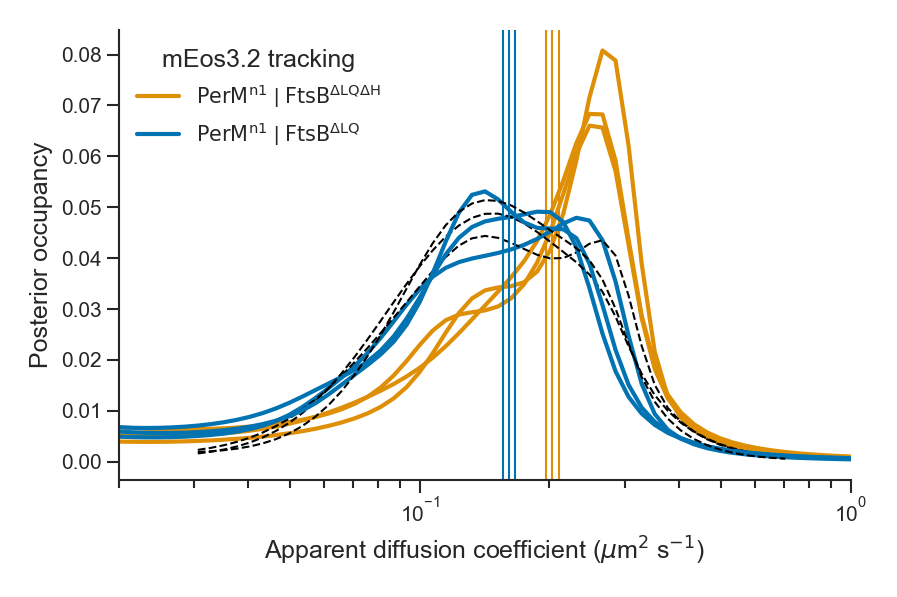

In [125]:
# test estimating mixed population

from saspt import normalize_2d
from scipy.stats import lognorm
from scipy.optimize import curve_fit

def mixed_population(x, f, scale, sigma):
    
    y2 = lognorm.pdf(x[0,:],s=sigma,scale=scale)
    y2 = y2/y2.sum()
    return (1-f)*x[1,:] + f*y2

def mixed_population_fixed(x, f):
    
    return (1-f)*x[1,:] + f*x[2,:]

dists = {c: normalize_2d(SAD.marginal_posterior_occs[df.index,:].copy()[:,use_coefs],axis=1) \
                for c, df in SAD.paths.groupby(SAD.condition_col)}

condition_names = ['PerMn1 FtsBΔLQΔH mEos3.2','PerMn1 FtsBΔLQ mEos3.2'] # Plot only FtsB tracking for PerM_n1 + dLQ or dLQdH condition

fig = plt.figure(figsize=(3,2))

mean_coeffs = []

fit_two_populations = True
unbound_condition = 'PerMn1 FtsBΔLQΔH mEos3.2'
bound_distribution = dists['PerMn1 FtsBΔLQ mNeonGreen'][0,:]
fitting = 'lognorm'
# fitting = 'empirical'

for n in range(len(condition_names)):

    mean_coeffs.append([])

    for i in range(len(dists[condition_names[n]])):
        
        sample_data = dists[condition_names[n]][i,:]

        label = pretty_labels[' '.join(condition_names[n].split(' ')[:-1])]
        c=color_dict[label]
        if i:
            label = None

        if plot_cumsum:
            plt.plot(plt_coefs,sample_data.cumsum(),c=c,label=label,linewidth=1)
        else:
            plt.plot(plt_coefs,sample_data,c=c,label=label,linewidth=1)

            if fit_two_populations and condition_names[n] != unbound_condition:

                fit_coefs = (0.03<=plt_coefs)&(plt_coefs<=0.75)

                if fitting=='lognorm':
                    x = np.vstack((plt_coefs[fit_coefs],dists[unbound_condition][i,fit_coefs]))
                    popt, pcov = curve_fit(mixed_population, x, sample_data[fit_coefs], p0 = [0.8, 0.1, 1])
                    unbound_distribution = mixed_population(x, *popt)
                    print('\n\tP_slow: {:.3}\n\tMean:   {:.3}\n\ts:      {:.3}'.format(*popt))
                else:
                    x = np.vstack((plt_coefs,dists[unbound_condition][i,:],bound_distribution))
                    popt, pcov = curve_fit(mixed_population_fixed, x, sample_data, p0 = [0.5])
                    unbound_distribution = mixed_population_fixed(x, *popt)
                    print(i,'{:.3}'.format(*popt))

                plt.plot(plt_coefs[fit_coefs],unbound_distribution,'k--',linewidth=0.5)

        plt.axvline(np.sum(plt_coefs*sample_data),color=c,linestyle='-',linewidth=0.5)
        plt.legend(frameon=False,title='mEos3.2 tracking')
                
        # print(condition_names[n],plot_diff_coefs[sample_data.argmax()], np.sum(plot_diff_coefs*sample_data),sep='\t')
        mean_coeffs[-1].append(np.sum(plot_diff_coefs*sample_data))

    print(condition_names[n],f'%0.4f'%np.mean(mean_coeffs[-1]),f'%0.4f'%np.std(mean_coeffs[-1]))
    
plt.xscale('log')   

plt.xlabel(r'Apparent diffusion coefficient ($\mu$m$^{2}$ s$^{-1}$)')
plt.ylabel('Posterior occupancy')
plt.xlim(xlim)

plt.tight_layout()
plt.savefig(figure_prefix + 'replicates_helix_effect_lognorm_fit.png',dpi=300)
plt.savefig(figure_prefix + 'replicates_helix_effect_lognorm_fit.svg',dpi=300)

In [102]:
SAD.conditions

array(['PerMn1 FtsBΔLQ mEos3.2', 'PerMn1 FtsBΔLQΔH mEos3.2',
       'Pf3 FtsBΔLQ mEos3.2', 'Pf3 FtsBΔLQΔH mEos3.2',
       'PerMn1 uninduced FtsBΔLQ mEos3.2', 'PerMn1 FtsBΔLQ mNeonGreen',
       'PerMn1 FtsBΔLQΔH mNeonGreen', 'Pf3 FtsBΔLQ mNeonGreen',
       'Pf3 FtsBΔLQΔH mNeonGreen'], dtype=object)

PerMn1 FtsBΔLQ mEos3.2	0.1665
PerMn1 FtsBΔLQ mNeonGreen	0.1453
PerMn1 FtsBΔLQΔH mEos3.2	0.2097
PerMn1 FtsBΔLQΔH mNeonGreen	0.1433
PerMn1 uninduced FtsBΔLQ mEos3.2	0.1963
Pf3 FtsBΔLQ mEos3.2	0.1989
Pf3 FtsBΔLQ mNeonGreen	0.2313
Pf3 FtsBΔLQΔH mEos3.2	0.2207
Pf3 FtsBΔLQΔH mNeonGreen	0.2216


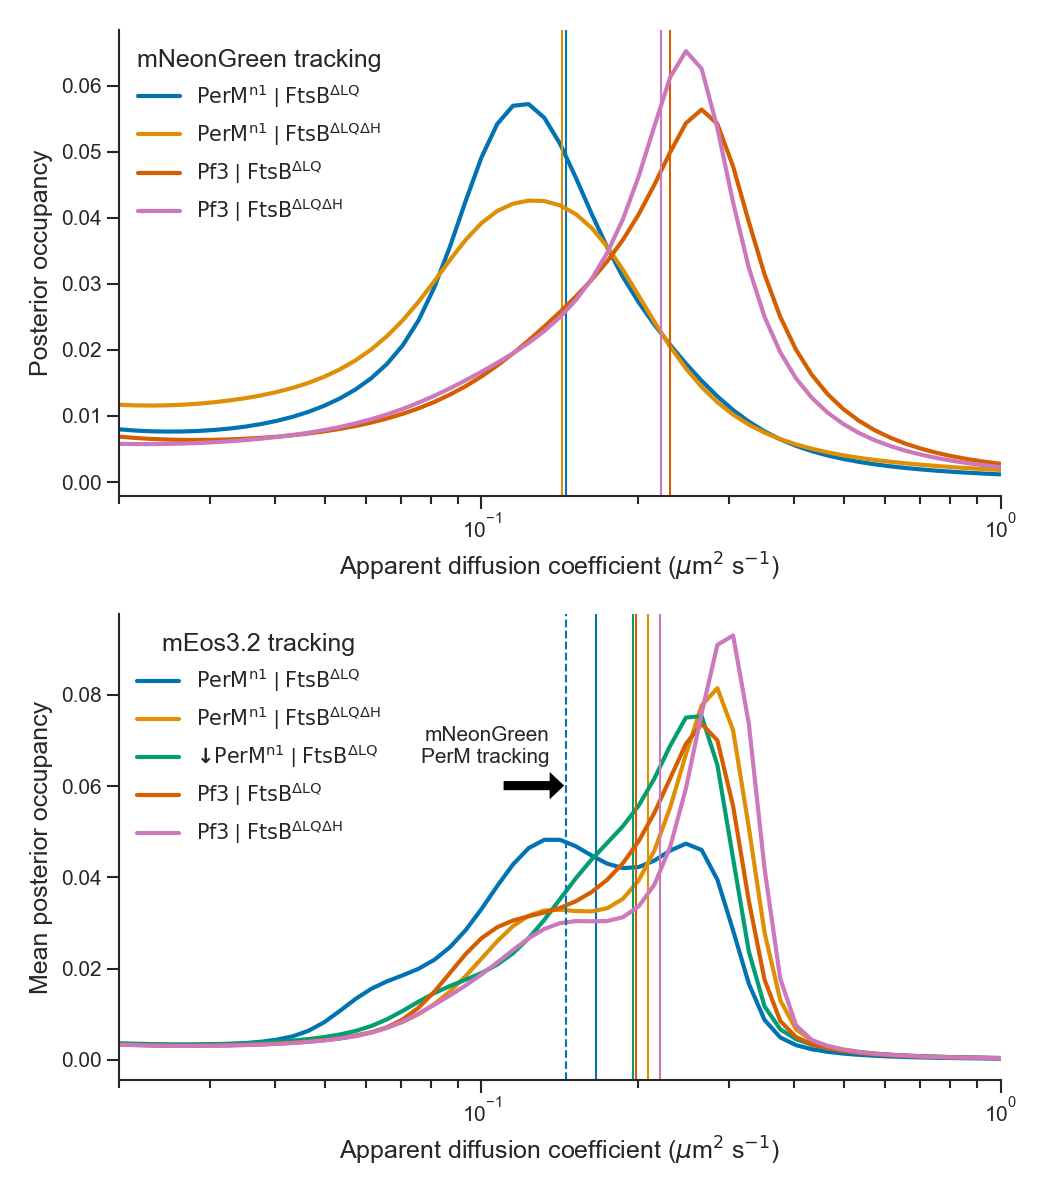

In [122]:
# Normalize and plot together Fig 4c

from saspt import normalize_2d
import pandas as pd, numpy as np, matplotlib.pyplot as plt, pickle, seaborn as sns

# exclude very close to zero to reduce noise and improve normalization
use_occs = posterior_occs[:,use_coefs]
use_occs = normalize_2d(use_occs, axis=1)
mean_PerM_coef = np.sum(plt_coefs * use_occs[1,:])

fig,ax = plt.subplots(2,1,sharex=False,sharey=False,figsize=(3.5,4))

for c in range(use_occs.shape[0]):

    label = pretty_labels[' '.join(posterior_names[c].split(' ')[:-1])]
    mean_coef = np.sum(plt_coefs*use_occs[c,:])

    if 'mNeonGreen' in posterior_names[c]:
        ax[0].plot(plt_coefs, use_occs[c,:], label=label,linewidth=1,c=color_dict[label])
        ax[0].legend(frameon=False,title='mNeonGreen tracking')
        ax[0].axvline(mean_coef,c=color_dict[label],ls='-',linewidth=0.5)
    else:
        ax[1].plot(plt_coefs, use_occs[c,:], label=label,linewidth=1,c=color_dict[label])
        ax[1].legend(frameon=False,title='mEos3.2 tracking')
        ax[1].axvline(mean_coef,c=color_dict[label],ls='-',linewidth=0.5)

    mean_coef = np.sum(plt_coefs*use_occs[c,:])
    print(posterior_names[c],f'%0.4f'%mean_coef,sep='\t')

ax[1].axvline(mean_PerM_coef,c=list(color_dict.values())[0],linestyle='--',linewidth=0.5)

text_height = ax[1].get_ylim()[1] * 2./3
ax[1].text(mean_PerM_coef-0.01,text_height,'mNeonGreen\nPerM tracking',horizontalalignment='right',size=5)
arrow_width = 0.025
ax[1].arrow(mean_PerM_coef-arrow_width-0.01,text_height-0.005,arrow_width,0,color='k', linewidth=0, width=0.002)
ax[0].set_ylabel('Posterior occupancy')
ax[1].set_ylabel('Mean posterior occupancy')

for i in range(2):
    ax[i].set_xscale('log')
    ax[i].set_xlim(xlim)
    ax[i].set_xlabel(r'Apparent diffusion coefficient ($\mu$m$^{2}$ s$^{-1}$)')

plt.xlabel(r'Apparent diffusion coefficient ($\mu$m$^{2}$ s$^{-1}$)')
plt.tight_layout()
plt.savefig(figure_prefix + 'mNeonGreen_mEos32_diffusion.png',dpi=300)
plt.savefig(figure_prefix + 'mNeonGreen_mEos32_diffusion.svg',dpi=300)
plt.show()